<a href="https://colab.research.google.com/github/whispermy/novatus_academia/blob/main/Week5_%EC%8B%A4%EC%8A%B54(%ED%95%AD%EB%A7%8C%EB%AC%BC%EB%8F%99%EB%9F%89_%EC%98%88%EC%B8%A1_keras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import datetime as dt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import random
random.seed(123)

### python graph 한글 깨짐 현상

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


### run time 다시 시작 후

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

## 1. Data Load

+ pandas를 이용해서 csv 파일을 Load

In [ ]:
data = pd.read_csv('./time_series.csv')

In [ ]:
data.head(3)

,date,고철/철강,모래/시멘트,광물성연료,비료,양곡/곡류,광석
0,2007-01-01,112553.220,98104.386,127427.76,84752.498,14392.540,23348.068
1,2007-02-01,137322.439,34945.768,149315.46,89502.042,60342.946,3600.000
2,2007-03-01,140753.862,63157.200,107161.28,101188.817,4581.000,12193.878


In [ ]:
data['date'] = pd.to_datetime(data.date)
data.set_index('date', inplace=True)

In [ ]:
data.tail()

,고철/철강,모래/시멘트,광물성연료,비료,양곡/곡류,광석
date,,,,,,
2017-08-01,58848.416,111624.552,133150.0,63325.420,68755.674,374361.873
2017-09-01,43474.539,92726.330,214902.1,88963.710,59017.942,263719.115
2017-10-01,50506.134,115819.578,141399.0,43620.339,99612.591,318631.360
2017-11-01,65772.104,157468.858,139312.0,137413.224,106007.990,277833.880
2017-12-01,68367.465,87226.016,152582.0,118757.310,63492.098,260788.697


In [ ]:
column_list = list(data.columns)

In [ ]:
column_list

['고철/철강', '모래/시멘트', '광물성연료', '비료', '양곡/곡류', '광석']

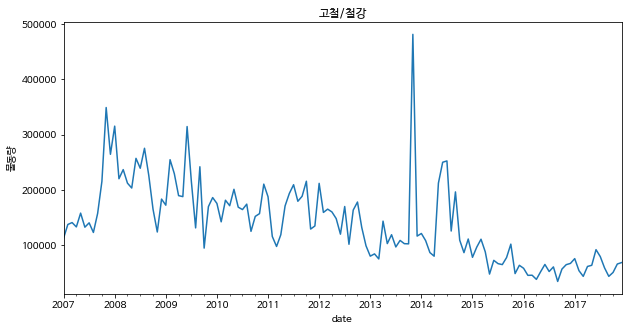

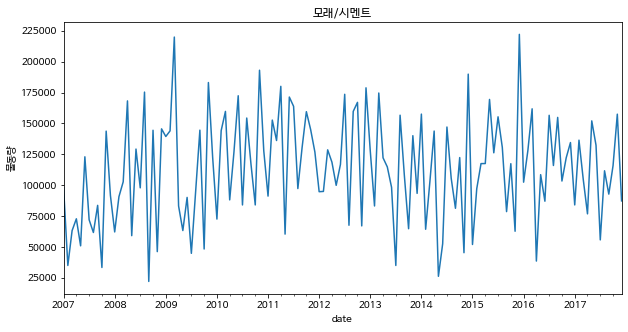

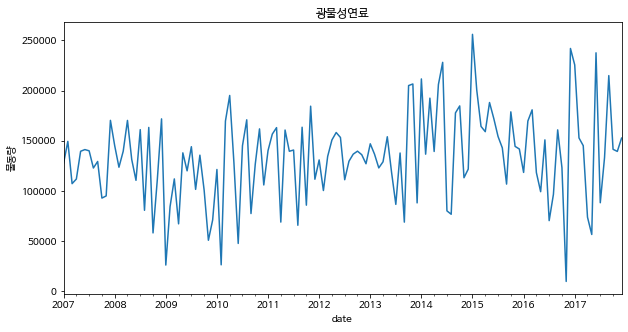

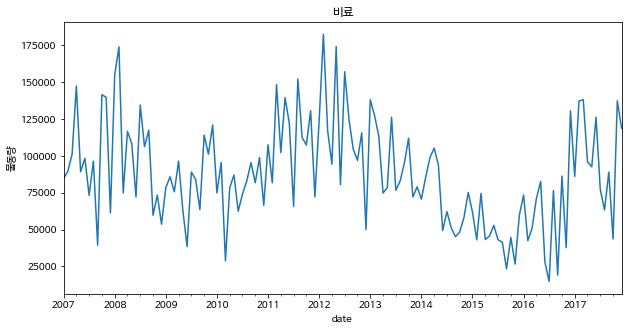

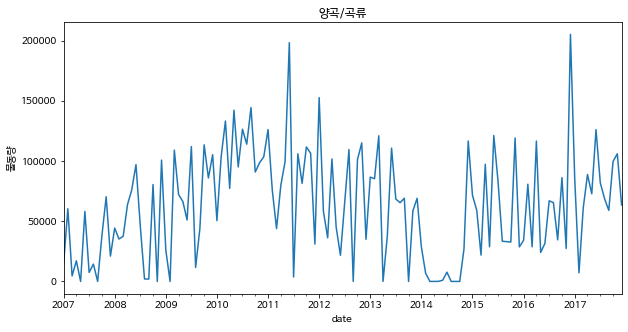

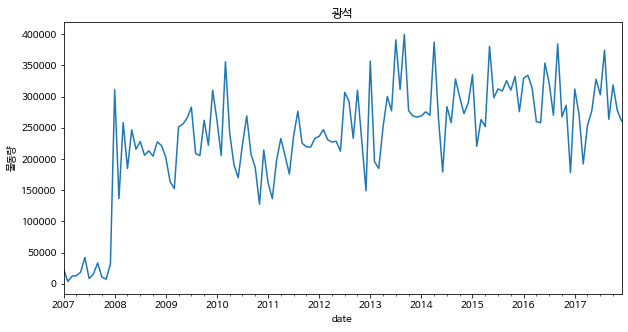

In [ ]:
for c in column_list:
    data.loc[:,c].plot(figsize=(10,5))
    plt.title(c)
    plt.ylabel('물동량')
    plt.show()

### Data Preprocessing
1. Train/test split

In [ ]:
column_list

['고철/철강', '모래/시멘트', '광물성연료', '비료', '양곡/곡류', '광석']

In [ ]:
item_dic = dict()
for idx, col in enumerate(column_list):
    print('반복문 순서 : ', idx, '\t', '순서에 맞는 리스트 요소 : ',col)
    item_dic[col] = idx

반복문 순서 :  0 	 순서에 맞는 리스트 요소 :  고철/철강
반복문 순서 :  1 	 순서에 맞는 리스트 요소 :  모래/시멘트
반복문 순서 :  2 	 순서에 맞는 리스트 요소 :  광물성연료
반복문 순서 :  3 	 순서에 맞는 리스트 요소 :  비료
반복문 순서 :  4 	 순서에 맞는 리스트 요소 :  양곡/곡류
반복문 순서 :  5 	 순서에 맞는 리스트 요소 :  광석


In [ ]:
item_dic 

{'고철/철강': 0, '광물성연료': 2, '광석': 5, '모래/시멘트': 1, '비료': 3, '양곡/곡류': 4}

In [ ]:
item_dic['고철/철강']

0

In [ ]:
item_dic['비료']

3

In [ ]:
item_dic['양곡/곡류']

4

In [ ]:
# timelag 설정 및 예측하고자하는 대분류 결정
seq_length=7
item ='비료'

In [ ]:
# train : test = 108(9년치 정보) : 30(이전에 6기 전에 정보를 받기 위해서)
# 시계열 데이터 이므로 연단위로 끊기 위해서
trainX = data.iloc[0:108].values
# 예측하고자 하는 y는 "비료"
trainY = data.iloc[0:108,item_dic[item]].values
testX = data.iloc[108-seq_length:].values
testY = data.iloc[108-seq_length:,item_dic[item]].values

In [ ]:
trainY=trainY.reshape(-1,1)
testY=testY.reshape(-1,1)

In [ ]:
print("trainY 차원 : {},\ntestY 차원 : {}".format(trainY.shape, testY.shape))

trainY 차원 : (108, 1),
testY 차원 : (31, 1)


2. min-max normalization

In [ ]:
minmax_scaler=MinMaxScaler()
minmax_scaler.fit(trainX)
trainX=minmax_scaler.transform(trainX)
testX=minmax_scaler.transform(testX)

In [ ]:
minmax_scaler_y=MinMaxScaler()
minmax_scaler_y.fit(trainY)
trainY=minmax_scaler_y.transform(trainY)
testY=minmax_scaler_y.transform(testY)

3. LSTM input tensor 생성

In [ ]:
# LSTM input 데이터로 변환
def build_dataset(X, y, seq_length):
    dataX=[]
    dataY=[]
    for i in range(0, len(X)-seq_length):
        _x=X[i:i+seq_length,:]
        _y=y[i+seq_length]
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX, dtype='float32'), np.array(dataY, dtype='float32')

In [ ]:
trainX_arr, trainY_arr=build_dataset(trainX, trainY, seq_length)
testX_arr, testY_arr=build_dataset(testX, testY, seq_length)

In [ ]:
print("trainX 차원 : {},\ntestX 차원 : {}".format(trainX_arr.shape, testX_arr.shape))

trainX 차원 : (101, 7, 6),
testX 차원 : (24, 7, 6)


### Keras LSTM model 학습

In [ ]:
tf.random.set_seed(777)

In [ ]:
epochs = 1000
batch_size = len(trainX_arr)

In [ ]:
models = Sequential([
    layers.LSTM(30, input_shape=(7,6)),
    layers.Dense(1)
])

In [ ]:
models.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30)                4440      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 4,471
Trainable params: 4,471
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError, MeanAbsoluteError

In [ ]:
rmse = RootMeanSquaredError(name='RMSE')
mae = MeanAbsoluteError(name='MAE')
models.compile(loss='mean_squared_error', optimizer='adagrad', metrics = [rmse, mae])

In [ ]:
lstm_models = models.fit(trainX_arr, trainY_arr, 
                         batch_size=batch_size,
                         epochs=epochs)

Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 0.5206 - RMSE: 0.7215 - MAE: 0.6790
Epoch 2/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.5033 - RMSE: 0.7095 - MAE: 0.6663
Epoch 3/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.4889 - RMSE: 0.6992 - MAE: 0.6554
Epoch 4/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4762 - RMSE: 0.6901 - MAE: 0.6457
Epoch 5/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.4647 - RMSE: 0.6817 - MAE: 0.6368
Epoch 6/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.4542 - RMSE: 0.6739 - MAE: 0.6285
Epoch 7/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.4444 - RMSE: 0.6667 - MAE: 0.6207
Epoch 8/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.4353 - RMSE: 0.6598 - MAE: 0.6133
Epoch 9/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.4267 - RMSE: 0.6533 - MAE: 0.6064
Epoch 10/1000
1/1 [========

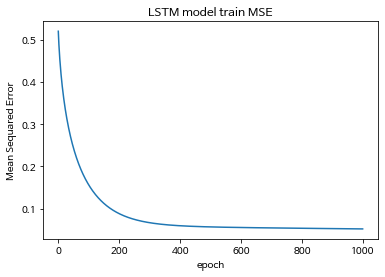

In [ ]:
plt.plot(lstm_models.history['loss'])
plt.xlabel("epoch")
plt.ylabel("Mean Sequared Error")
plt.title("LSTM model train MSE")
plt.show()

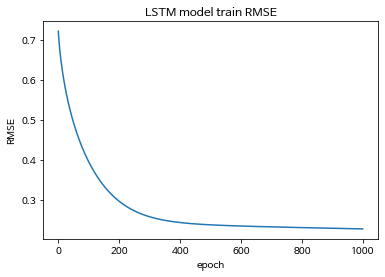

In [ ]:
plt.plot(lstm_models.history['RMSE'])
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.title("LSTM model train RMSE")
plt.show()

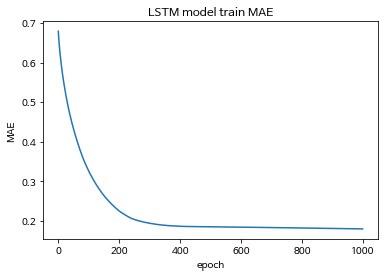

In [ ]:
plt.plot(lstm_models.history['MAE'])
plt.xlabel("epoch")
plt.ylabel("MAE")
plt.title("LSTM model train MAE")
plt.show()

### model evaluation

+ MSE

$$ MSE = \frac{\sum^{N}_{n=1}(y_n - \hat{y}_n)^2}{N}$$

+ RMSE

$$ RMSE = \sqrt{\frac{\sum^{N}_{n=1}(y_n - \hat{y}_n)^2}{N}}$$

+ MAE

$$ MAE = \frac{\sum^{N}_{n=1}|y_n - \hat{y}_n|}{N} $$

+ MAPE

+ 우리가 위에서 학습했던 값은 0과 1사이로 정규화된 값임
    - 예측된 값 또한 0과 1사이로 정규화된 값으로 나오게 됨
    - 예측된 값을 다시 원래 값으로 변화 시켜주어야함 (inverse_transform)

In [ ]:
pred_test = models.predict(testX_arr)
y_pred_inv = minmax_scaler_y.inverse_transform(pred_test)
y_truth_inv = minmax_scaler_y.inverse_transform(testY_arr)

+ inverse transform의 값으로 다시 변환 시킨 데이터를 이용해서 모델 검증을 수행

In [ ]:
MSE = mean_squared_error(y_truth_inv, y_pred_inv)
RMSE = np.sqrt(mean_squared_error(y_truth_inv, y_pred_inv))
MAE = mean_absolute_error(y_truth_inv, y_pred_inv)

In [ ]:
final_result = pd.DataFrame([[MSE, RMSE, MAE]], 
                            index = ['LSTM'],
                            columns=['MSE', 'RMSE', 'MAE'])
final_result

,MSE,RMSE,MAE
LSTM,1.539547e+09,39237.0625,32682.375


In [ ]:
test_df = pd.DataFrame([y_pred_inv.squeeze().tolist(),
                        y_truth_inv.squeeze().tolist()], index=['pred', 'true']).T

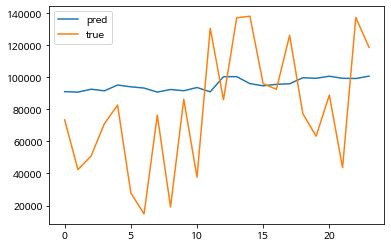

In [ ]:
test_df.plot()